In [1]:
from net import Net
import torch
from torch.autograd import grad
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from math import pi

In [2]:
def d(f, x):
    return grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True, only_inputs=True)[0]
    #gradoutputs 向量与f中的自变量有关   create_graph可以计算高阶导数

In [3]:
def PDE(u, t, x, nu):
    return d(u, t) + u * d(u, x) - nu * d(d(u, x), x)
    #PDE函数u_t + u*u_x -nu*u_xx 应该趋于0

In [9]:
nu = 0.01 / pi
lr = 0.001    #学习率
epochs = 12000   #12000轮周期
t_left, t_right = 0., 1.   #边界t在0-1
x_left, x_right = -1., 1.   #x在-1 -1
n_f, n_b_1, n_b_2 = 10000, 5000, 5000   #训练点数量 残差f:10000个 边界：10000个 共20000
    # test data
data = scipy.io.loadmat('./result/burgers_shock.mat')
#有三个double数据，分别是
#x :256*1 是-1到1的均分
#t :100*1 0-1
#usol精确解 256*100
Exact = np.real(data['usol']).T  #real函数返回实部，提取出精确解 加转置是之后按行展开对应解
t = data['t'].flatten()[:, None]  #展开成1维度，flatten展0维，[:,none]加一维
x = data['x'].flatten()[:, None]
X, T = np.meshgrid(x, t)  #生成二维网格
s_shape = X.shape   #100行256列
s_shape

(100, 256)

In [14]:
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
# 在水平方向上平铺(25600, 2) hstack按行加，X flatten 100*256  T同理
X_star

array([[-1.        ,  0.        ],
       [-0.99215686,  0.        ],
       [-0.98431373,  0.        ],
       ...,
       [ 0.98431373,  0.99      ],
       [ 0.99215686,  0.99      ],
       [ 1.        ,  0.99      ]])

In [15]:


X_star = X_star.astype(np.float32) #数据转换为np
X_star = torch.from_numpy(X_star).cuda().requires_grad_(True)  #换成tensor张量 Gpu计算，可求导
u_star = Exact.flatten()[:, None] #精确解
u_star = u_star.astype(np.float32)
u_star = torch.from_numpy(u_star).cuda().requires_grad_(True)
u_star[0:200,:]

tensor([[ 1.2246e-16],
        [ 2.4637e-02],
        [ 4.9260e-02],
        [ 7.3853e-02],
        [ 9.8400e-02],
        [ 1.2289e-01],
        [ 1.4730e-01],
        [ 1.7163e-01],
        [ 1.9585e-01],
        [ 2.1995e-01],
        [ 2.4391e-01],
        [ 2.6773e-01],
        [ 2.9139e-01],
        [ 3.1487e-01],
        [ 3.3816e-01],
        [ 3.6124e-01],
        [ 3.8411e-01],
        [ 4.0674e-01],
        [ 4.2912e-01],
        [ 4.5124e-01],
        [ 4.7309e-01],
        [ 4.9466e-01],
        [ 5.1592e-01],
        [ 5.3687e-01],
        [ 5.5749e-01],
        [ 5.7777e-01],
        [ 5.9771e-01],
        [ 6.1728e-01],
        [ 6.3647e-01],
        [ 6.5528e-01],
        [ 6.7370e-01],
        [ 6.9170e-01],
        [ 7.0928e-01],
        [ 7.2643e-01],
        [ 7.4314e-01],
        [ 7.5940e-01],
        [ 7.7520e-01],
        [ 7.9053e-01],
        [ 8.0538e-01],
        [ 8.1974e-01],
        [ 8.3360e-01],
        [ 8.4696e-01],
        [ 8.5980e-01],
        [ 8

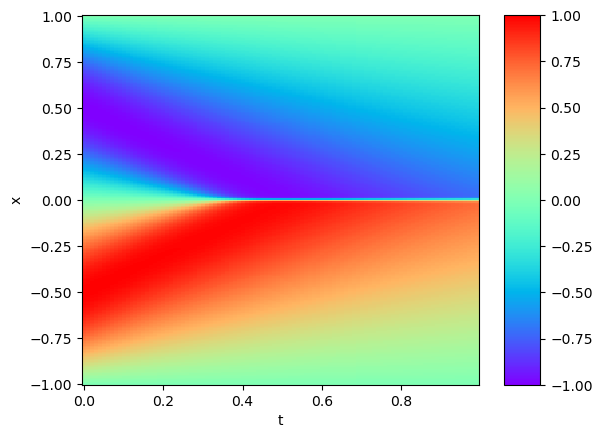

In [6]:
 os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.cuda('cpu')
#加载gpu0

PINN = Net(seq_net=[2, 20, 20, 20, 20, 20, 20, 1], activation=torch.tanh).to(device)
#pinn网络设置 指定到gpu上运算

optimizer = torch.optim.Adam(PINN.parameters(), lr)
#优化器
criterion = torch.nn.MSELoss()
#残差函数 均方误差 预测值与真实值用均方误差

loss_history = []
#损失函数历史
mse_loss = []
#均方误差损失函数

plt.cla()  #清除axes 画图
mse_test = u_star #残差精确测试项提取
'''
精确解画图
'''
plt.pcolormesh(np.squeeze(t, axis=1), np.squeeze(x, axis=1),
               mse_test.cpu().detach().numpy().reshape(s_shape).T, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
#rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-1, 1)
#设置颜色组成及对应关系
# plt.xticks([])
# plt.yticks([])
plt.xlabel('t')
plt.ylabel('x')
plt.savefig('./result_plot/Burger1d_exact.png', bbox_inches='tight', format='png')
#存图片
#
plt.show()

In [7]:
#循环

In [8]:
epoch=1

In [9]:
 optimizer.zero_grad()

In [10]:
t_f = ((t_left + t_right) / 2 + (t_right - t_left) *
               (torch.rand(size=(n_f, 1), dtype=torch.float, device=device) - 0.5)
               ).requires_grad_(True)

In [13]:
x_f = ((x_left + x_right) / 2 + (x_right - x_left) *
               (torch.rand(size=(n_f, 1), dtype=torch.float, device=device) - 0.5)
               ).requires_grad_(True)
        ##随机点x属于[-1,1] 均匀分布 用n_f=10000个点 属于pde内部随机选点

In [14]:
u_f = PINN(torch.cat([t_f, x_f], dim=1))
        #内部点pinn得到的函数值
u_f

tensor([[-0.0461],
        [-0.0310],
        [ 0.0147],
        ...,
        [-0.0242],
        [-0.0220],
        [ 0.0370]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
PDE_ = PDE(u_f, t_f, x_f, nu)
        #之前写的pde函数
PDE_

tensor([[-0.0107],
        [-0.0133],
        [-0.0144],
        ...,
        [-0.0134],
        [-0.0146],
        [-0.0120]], device='cuda:0', grad_fn=<SubBackward0>)

In [16]:
mse_PDE = criterion(PDE_, torch.zeros_like(PDE_))
mse_PDE

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)

In [19]:
x_rand = ((x_left + x_right) / 2 + (x_right - x_left) *(torch.rand(size=(n_b_1, 1), dtype=torch.float, device=device) - 0.5)).requires_grad_(True)
#随机点x属于[-1,1] 均匀分布 用n_b_1=5000个点 属于pde边界点t=0
t_b = (t_left * torch.ones_like(x_rand)).requires_grad_(True)
#t_b维度上对齐x_rand，属于边界点t=0
u_b_1 = PINN(torch.cat([t_b, x_rand], dim=1)) + torch.sin(pi * x_rand)
u_b_1
#t=0,x=[-1,1]上边界点的函数值，要接近-sin(x*pi),现在要趋近于0

tensor([[-0.4133],
        [-0.9781],
        [ 0.9551],
        ...,
        [ 0.4268],
        [ 0.1556],
        [ 1.0244]], device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
t_rand = ((t_left + t_right) / 2 + (t_right - t_left) *(torch.rand(size=(n_b_2, 1), dtype=torch.float, device=device) - 0.5)).requires_grad_(True)
#随机点t属于[0,1] 均匀分布 用n_b_2=5000个点  属于pde边界随机选点
x_b_1 = (x_left * torch.ones_like(t_rand)).requires_grad_(True)
x_b_2 = (x_right * torch.ones_like(t_rand)).requires_grad_(True)
#两个边界条件x=-1与x=1
u_b_2 = PINN(torch.cat([t_rand, x_b_1], dim=1))
#左边界的函数值，应该趋近于0
u_b_3 = PINN(torch.cat([t_rand, x_b_2], dim=1))
#右边界的函数值，应该趋近与0

In [21]:
mse_BC_1 = criterion(u_b_1, torch.zeros_like(u_b_1))
mse_BC_2 = criterion(u_b_2, torch.zeros_like(u_b_2))
mse_BC_3 = criterion(u_b_3, torch.zeros_like(u_b_3))
#边界条件的损失函数
mse_BC = mse_BC_1 + mse_BC_2 + mse_BC_3
mse_BC

tensor(0.5349, device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
# loss函数综合方程内部与边界条件，权重比例为1：1
loss = 1 * mse_PDE + 1 * mse_BC
loss

tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>)

In [35]:
# 预测解与真实解的差距
x_pred = X_star[:, 0:1]
t_pred = X_star[:, 1:2]
u_pred = PINN(torch.cat([x_pred,t_pred], dim=1))
mse_test = criterion(u_pred, u_star)
mse_test

tensor(0.3727, device='cuda:0', grad_fn=<MseLossBackward0>)

In [41]:
loss_history.append([mse_PDE.item(), mse_BC.item(), mse_test.item()])
mse_loss.append(loss.item())


[tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.5351, device='cuda:0', grad_fn=<AddBackward0>),
 0.5351296067237854,
 0.5351296067237854]

In [43]:
if (epoch + 1) % 1000 == 0:
    print(
    'epoch:{:05d}, PDE: {:.08e}, BC: {:.08e},  loss: {:.08e}'.format(
        epoch, mse_PDE.item(), mse_BC.item(), loss.item()
    )
)
#1000个epoch一轮报告数据，依次是PDE方程的损失函数，边界条件的损失函数，总的损失函数

In [44]:
loss.backward()

In [45]:
optimizer.step()
        # 更新所有参数

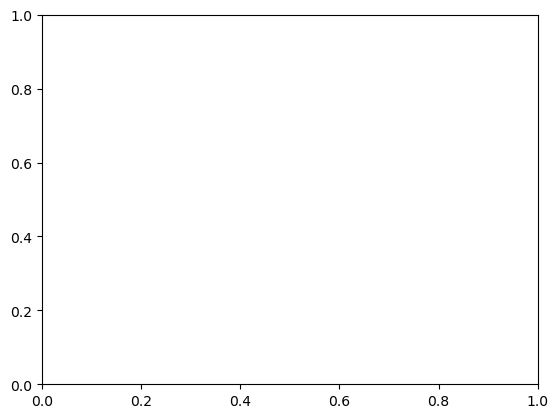

<Figure size 1200x400 with 0 Axes>

In [46]:
plt.cla()
fig = plt.figure(figsize=(12, 4))

In [95]:
xx = torch.linspace(0, 1, 1000).cpu()
yy = torch.linspace(-1, 1, 1000).cpu()
x1, y1 = torch.meshgrid([xx, yy])
#划分网格
x1

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.9980, 0.9980, 0.9980,  ..., 0.9980, 0.9980, 0.9980],
        [0.9990, 0.9990, 0.9990,  ..., 0.9990, 0.9990, 0.9990],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [96]:
s1 = x1.shape
x1 = x1.reshape((-1, 1))
y1 = y1.reshape((-1, 1))
            #换成一列数据
out = torch.cat([x1, y1], dim=1).to(device)    
z = PINN(out)
z_out = z.reshape(s1)
z_out

tensor([[-0.0326, -0.0326, -0.0325,  ...,  0.0437,  0.0438,  0.0438],
        [-0.0326, -0.0326, -0.0325,  ...,  0.0437,  0.0438,  0.0438],
        [-0.0326, -0.0326, -0.0325,  ...,  0.0437,  0.0438,  0.0438],
        ...,
        [-0.0369, -0.0368, -0.0368,  ...,  0.0338,  0.0338,  0.0339],
        [-0.0369, -0.0368, -0.0368,  ...,  0.0338,  0.0338,  0.0339],
        [-0.0369, -0.0368, -0.0368,  ...,  0.0337,  0.0338,  0.0339]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [97]:
out = z_out.cpu().T.detach().numpy()
out

array([[-0.03261375, -0.03262072, -0.03262768, ..., -0.0368797 ,
        -0.03688191, -0.03688411],
       [-0.03255909, -0.03256609, -0.03257304, ..., -0.03683841,
        -0.03684063, -0.03684285],
       [-0.03250434, -0.03251134, -0.03251831, ..., -0.03679703,
        -0.03679926, -0.03680149],
       ...,
       [ 0.04371469,  0.04370775,  0.04370079, ...,  0.03377212,
         0.03375965,  0.03374718],
       [ 0.04376894,  0.04376201,  0.04375506, ...,  0.03383685,
         0.03382438,  0.03381192],
       [ 0.04382309,  0.04381616,  0.04380924, ...,  0.0339015 ,
         0.03388905,  0.03387659]], dtype=float32)

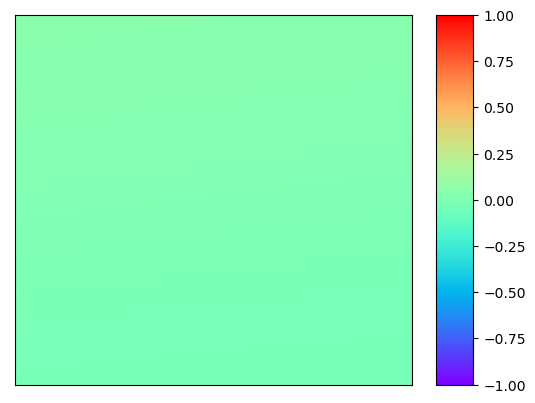

In [109]:
plt.pcolormesh(xx, yy, out, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-1, 1)
plt.xticks([])
plt.yticks([])
# plt.savefig('./result_plot/Burger1d_pred_{}.png'.format(epoch + 1), bbox_inches='tight', format='png')
plt.show()

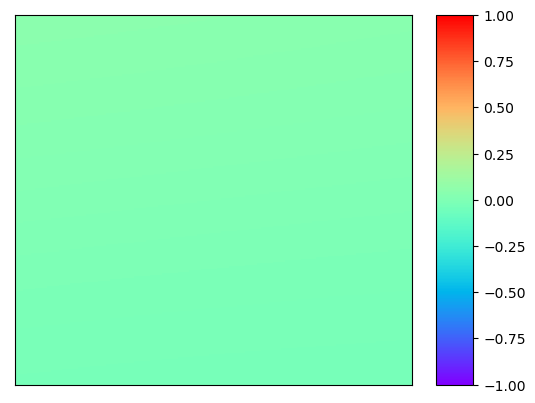

In [110]:
#按照给的精确解的点来画
x_pred = X_star[:, 0:1]
t_pred = X_star[:, 1:2]
u_pred = PINN(torch.cat([t_pred, x_pred], dim=1))
plt.pcolormesh(np.squeeze(t, axis=1), np.squeeze(x, axis=1),
               u_pred.cpu().detach().numpy().reshape(s_shape).T, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-1, 1)
plt.xticks([])
plt.yticks([])
plt.savefig('./result_plot/Burger1d_pred_{}.png'.format(epoch + 1), bbox_inches='tight', format='png')
plt.show()

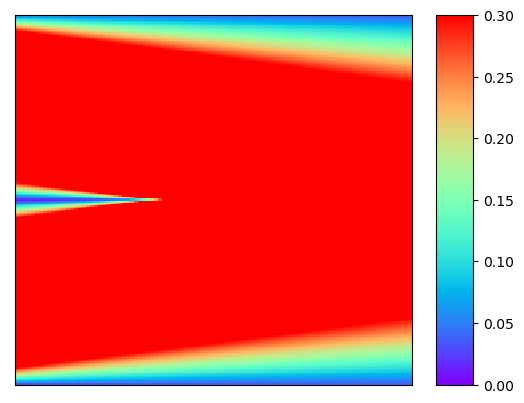

In [111]:
plt.cla()
mse_test = abs(u_pred - u_star)#求差的绝对值
plt.pcolormesh(np.squeeze(t, axis=1), np.squeeze(x, axis=1),
               mse_test.cpu().detach().numpy().reshape(s_shape).T, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(0, 0.3)
plt.xticks([])
plt.yticks([])
plt.savefig('./result_plot/Burger1d_error_{}.png'.format(epoch + 1), bbox_inches='tight', format='png')
plt.show()

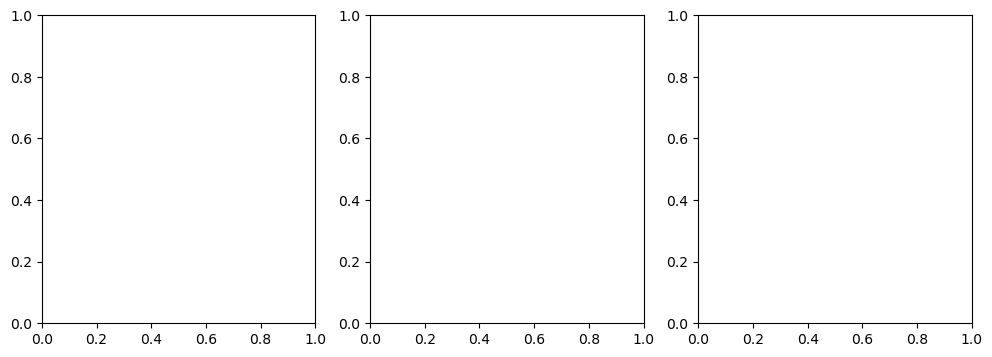

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

Text(0.5, 1.0, 't = 0.75')

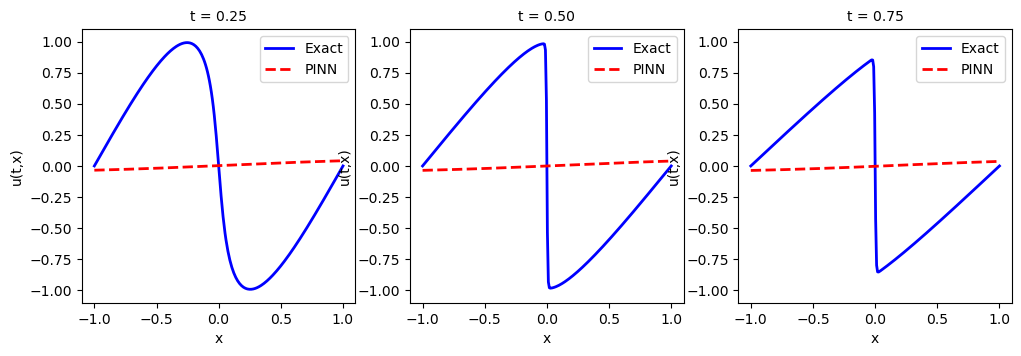

In [141]:
#三幅子图，分别是t=0.25,t=0.5,t=0.75时的x图
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
x_25 = x.astype(np.float32)
x_25 = torch.from_numpy(x_25).cuda().requires_grad_(True)
t_25 = (0.25 * torch.ones_like(x_25)).requires_grad_(True)
u_25 = PINN(torch.cat([t_25, x_25], dim=1))
ax[0].plot(x, Exact[25, :], 'b-', linewidth=2)#蓝线是精确解
ax[0].plot(x, u_25.reshape((-1, 1)).detach().cpu().numpy(), 'r--', lw='2')#红是预测
ax[0].legend(labels=['Exact','PINN'])
ax[0].set_xlabel('x')
ax[0].set_ylabel('u(t,x)')
ax[0].axis('square')
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title('t = 0.25', fontsize=10)

 #第二幅子图
t_50 = (0.5 * torch.ones_like(x_25)).requires_grad_(True)
u_50 = PINN(torch.cat([t_50, x_25], dim=1))
ax[1].plot(x, Exact[50, :], 'b-', linewidth=2)
ax[1].plot(x, u_50.reshape((-1, 1)).detach().cpu().numpy(), 'r--', linewidth=2)
ax[1].legend(labels=['Exact', 'PINN'])
ax[1].set_xlabel('x')
ax[1].set_ylabel('u(t,x)')
ax[1].axis('square')
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title('t = 0.50', fontsize=10)

# 第三幅子图
t_75 = (0.75 * torch.ones_like(x_25)).requires_grad_(True)
u_75 = PINN(torch.cat([t_75, x_25], dim=1))
ax[2].plot(x, Exact[75, :], 'b-', linewidth=2)
ax[2].plot(x, u_75.reshape((-1, 1)).detach().cpu().numpy(), 'r--', linewidth=2)
ax[2].legend(labels=['Exact', 'PINN'])
ax[2].set_xlabel('x')
ax[2].set_ylabel('u(t,x)')
ax[2].axis('square')
ax[2].set_xlim([-1.1, 1.1])
ax[2].set_ylim([-1.1, 1.1])
ax[2].set_title('t = 0.75', fontsize=10)

Text(0.5, 1.0, 't = 0.50')